# Librerías


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from arima import (
    naive_model,
    arima_rolling_training_rolling_prediction,
    sarima_rolling_training_rolling_prediction,
    plot_arima,
)

from sklearn.metrics import root_mean_squared_error

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX


# pmdarima
from pmdarima import auto_arima

## Leemos la data


In [2]:
train_df = pd.read_parquet("../../../data/time_series/train_df.parquet").asfreq("D")
validation_df = pd.read_parquet(
    "../../../data/time_series/validation_df.parquet"
).asfreq("D")
test_df = pd.read_parquet("../../../data/time_series/test_df.parquet").asfreq("D")

# Arima optimo

Primero vamos a encontrar el modelo ARIMA óptimo para la serie de tiempo. Para esto vamos a utilizar la función auto_arima de la librería pmdarima.


In [3]:
model_pmd_arima = auto_arima(
    train_df["gap"],
    max_p=10,
    m=7,
    maxiter=500,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
)

# Resumen del modelo
print(model_pmd_arima.summary())

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=99001.289, Time=0.16 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=98903.473, Time=0.61 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=98866.240, Time=2.00 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=98885.407, Time=0.42 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.47 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=24.64 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=98847.455, Time=1.82 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=19.20 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=54.43 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=97645.023, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=97410.740, Time=2.73 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=97359.585, Time=3.45 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=97361.606, Time=0.94 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=10.56 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=41.37 sec
 ARIMA(0,1,1)(2,0,0)[7] in

KeyboardInterrupt: 

In [ ]:
arima_order = (1, 1, 3)
seasonal_order = (1, 0, 0, 7)

# Model Building

## Naive model


In [ ]:
rmse_naive, mape_naive = naive_model(
    train_df=train_df, test_df=validation_df, column_name="gap"
)

Naive approach:
RMSE: 16268.436428659435
MAPE: 17.11%


## Arima statsmodels


In [ ]:
model = SARIMAX(
    endog=train_df["gap"], order=arima_order, seasonal_order=seasonal_order, freq="D"
)
model_res = model.fit(disp=0)
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                gap   No. Observations:                 4992
Model:             SARIMAX(1, 1, 3)x(1, 0, [], 7)   Log Likelihood              -48563.258
Date:                            Wed, 29 May 2024   AIC                          97138.517
Time:                                    09:48:17   BIC                          97177.609
Sample:                                11-01-2001   HQIC                         97152.219
                                     - 07-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4870      0.098      4.993      0.000       0.296       0.678
ma.L1         -1.1112      0.097    -11.492      0.000      -1.301      -0.922
ma.L2          0.0945      0.062      1.519      0.129      -0.027       0.216
ma.L3          0.1289      0.016      7.891      0.000       0.097       0.161
ar.S.L7        0.2108      0.006     36.423      0.000       0.199       0.222
sigma2      1.703e+07   2.46e-08   6.94e+14      0.000     1.7e+07     1.7e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):            326121.74
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):             725.80   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.8e+29. Standard errors may be unstable.
"""

In [ ]:
predictions_statsmodels = model_res.get_forecast(
    steps=len(validation_df["gap"])
).predicted_mean
predictions_statsmodels.name = "predictions_statsmodels"

## Arima Skforecaster


In [ ]:
model = Sarimax(order=arima_order, seasonal_order=seasonal_order)
model.fit(y=train_df["gap"])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                gap   No. Observations:                 4992
Model:             SARIMAX(1, 1, 3)x(1, 0, [], 7)   Log Likelihood              -48563.258
Date:                            Wed, 29 May 2024   AIC                          97138.517
Time:                                    09:48:18   BIC                          97177.609
Sample:                                11-01-2001   HQIC                         97152.219
                                     - 07-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4870      0.098      4.993      0.000       0.296       0.678
ma.L1         -1.1112      0.097    -11.492      0.000      -1.301      -0.922
ma.L2          0.0945      0.062      1.519      0.129      -0.027       0.216
ma.L3          0.1289      0.016      7.891      0.000       0.097       0.161
ar.S.L7        0.2108      0.006     36.423      0.000       0.199       0.222
sigma2      1.703e+07   2.46e-08   6.94e+14      0.000     1.7e+07     1.7e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):            326121.74
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):             725.80   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.8e+29. Standard errors may be unstable.
"""

In [ ]:
predictions_skforecast = model.predict(steps=len(validation_df["gap"]))
predictions_skforecast.columns = ["skforecast"]

## Modelo con pmdarima


In [ ]:
model_pmd_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4992
Model:             SARIMAX(1, 1, 3)x(1, 0, [], 7)   Log Likelihood              -48545.202
Date:                            Wed, 29 May 2024   AIC                          97104.403
Time:                                    09:48:18   BIC                          97150.011
Sample:                                11-01-2001   HQIC                         97120.390
                                     - 07-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     53.5535     21.638      2.475      0.013      11.143      95.964
ar.L1         -0.9082      0.012    -77.369      0.000      -0.931      -0.885
ma.L1          0.3128      0.013     24.341      0.000       0.288       0.338
ma.L2         -0.7272      0.009    -84.123      0.000      -0.744      -0.710
ma.L3         -0.2293      0.006    -37.239      0.000      -0.241      -0.217
ar.S.L7        0.2432      0.006     42.144      0.000       0.232       0.254
sigma2      1.703e+07      0.002   6.86e+09      0.000     1.7e+07     1.7e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):            351025.79
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):             552.83   Skew:                             2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.96e+23. Standard errors may be unstable.
"""

In [ ]:
predictions_pdmarima = model_pmd_arima.predict(len(validation_df["gap"]))
predictions_pdmarima.name = "predictions_pdmarima"

## Grafica de resultados


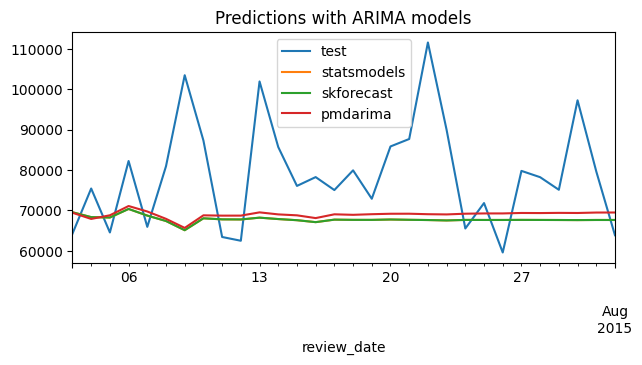

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
validation_df["gap"].plot(ax=ax, label="test")
predictions_statsmodels.plot(ax=ax, label="statsmodels")
predictions_skforecast.plot(ax=ax, label="skforecast")
predictions_pdmarima.plot(ax=ax, label="pmdarima")
ax.set_title("Predictions with ARIMA models")
ax.legend()

In [ ]:
rmse_statsmodels = root_mean_squared_error(
    predictions_statsmodels, validation_df["gap"]
)
rmse_skforecast = root_mean_squared_error(predictions_skforecast, validation_df["gap"])
rmse_pmdarima = root_mean_squared_error(predictions_pdmarima, validation_df["gap"])

In [ ]:
print(f"RMSE statsmodels: {rmse_statsmodels}")
print(f"RMSE skforecast: {rmse_skforecast}")
print(f"RMSE pmdarima: {rmse_pmdarima}")

rmse statsmodels: 17137.915142801918
rmse skforecast: 17137.915142801918
rmse pmdarima: 16358.465265538322


## ARIMA rolling training rolling prediction utilizando VALIDATION


In [ ]:
(
    mape_arima_rolling,
    rmse_arima_rolling,
    [predictions__arima_rolling, values__arima_rolling],
) = arima_rolling_training_rolling_prediction(
    train_df=train_df, test_df=validation_df, arima_order=arima_order, column="gap"
)

ARIMA Order: (1, 1, 3)
RMSE: 13247.055735224394
MAPE: 12.86%


In [ ]:
plot_arima(
    test_df,
    values__arima_rolling,
    predictions__arima_rolling,
    title="Comparación de los valores reales con las predicciones del modelo ARIMA usando ROLLING TRAINING - ROLLING PREDICTIONS",
)

## Sarima Rolling training rolling prediction utilizando VALIDATION


In [ ]:
(
    mape_arima_rolling,
    rmse_arima_rolling,
    [predictions__sarima_rolling, values__sarima_rolling],
) = sarima_rolling_training_rolling_prediction(
    train_df=train_df,
    test_df=validation_df,
    arima_order=arima_order,
    seasonal_order=seasonal_order,
    column="gap",
)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73509D+00    |proj g|=  7.91340D-02

At iterate    5    f=  9.72830D+00    |proj g|=  7.94733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   1.283D-05   9.728D+00
  F =   9.7282168404458478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.72836D+00    |proj g|=  7.77293D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   7.488D-05   9.728D+00
  F =   9.7282758365678870     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73578D+00    |proj g|=  7.95987D-02


 This problem is unconstrained.



At iterate    5    f=  9.72872D+00    |proj g|=  6.99239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   4.085D-05   9.729D+00
  F =   9.7286563318058388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73570D+00    |proj g|=  7.88371D-02


 This problem is unconstrained.



At iterate    5    f=  9.72886D+00    |proj g|=  6.61640D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   4.997D-05   9.729D+00
  F =   9.7287926350703309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73638D+00    |proj g|=  7.81973D-02


 This problem is unconstrained.



At iterate    5    f=  9.72989D+00    |proj g|=  6.01250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   2.917D-05   9.730D+00
  F =   9.7298399265648676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73684D+00    |proj g|=  7.86542D-02


 This problem is unconstrained.



At iterate    5    f=  9.73015D+00    |proj g|=  6.40719D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   3.935D-05   9.730D+00
  F =   9.7300850780164669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73848D+00    |proj g|=  8.09356D-02

At iterate    5    f=  9.73135D+00    |proj g|=  8.04628D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   8.835D-05   9.731D+00
  F =   9.7312640048496384     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.73725D+00    |proj g|=  4.56036D-03

At iterate   10    f=  9.73722D+00    |proj g|=  9.49160D-04

At iterate   15    f=  9.73721D+00    |proj g|=  1.62668D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   5.712D-06   9.737D+00
  F =   9.7372130732535513     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74311D+00    |proj g|=  7.25868D-02


 This problem is unconstrained.



At iterate    5    f=  9.73732D+00    |proj g|=  6.22331D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   5.593D-05   9.737D+00
  F =   9.7372684154216440     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74607D+00    |proj g|=  7.82735D-02

At iterate    5    f=  9.73891D+00    |proj g|=  9.36643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   3.364D-05   9.739D+00
  F =   9.7388045736629483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.73931D+00    |proj g|=  1.07222D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   8.575D-06   9.739D+00
  F =   9.7391837075942806     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75130D+00    |proj g|=  7.91387D-02


 This problem is unconstrained.



At iterate    5    f=  9.74319D+00    |proj g|=  1.01380D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.716D-05   9.743D+00
  F =   9.7431256023963453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75106D+00    |proj g|=  7.71861D-02


 This problem is unconstrained.



At iterate    5    f=  9.74310D+00    |proj g|=  9.75721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   4.242D-05   9.743D+00
  F =   9.7430392833367403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75111D+00    |proj g|=  7.76876D-02


 This problem is unconstrained.



At iterate    5    f=  9.74320D+00    |proj g|=  9.51178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   5.163D-05   9.743D+00
  F =   9.7431379057534500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75168D+00    |proj g|=  7.89039D-02


 This problem is unconstrained.



At iterate    5    f=  9.74333D+00    |proj g|=  9.84284D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   4.168D-05   9.743D+00
  F =   9.7432643557596492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75128D+00    |proj g|=  7.74980D-02


 This problem is unconstrained.



At iterate    5    f=  9.74340D+00    |proj g|=  9.69938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   3.027D-05   9.743D+00
  F =   9.7433352373689015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75167D+00    |proj g|=  7.89431D-02


 This problem is unconstrained.



At iterate    5    f=  9.74343D+00    |proj g|=  9.95643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   1.143D-05   9.743D+00
  F =   9.7433649981349912     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75160D+00    |proj g|=  7.90110D-02


 This problem is unconstrained.



At iterate    5    f=  9.74347D+00    |proj g|=  9.71033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.523D-05   9.743D+00
  F =   9.7434090679116157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75145D+00    |proj g|=  7.85405D-02


 This problem is unconstrained.



At iterate    5    f=  9.74346D+00    |proj g|=  9.58603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   3.791D-05   9.743D+00
  F =   9.7434003025728462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75168D+00    |proj g|=  7.91486D-02


 This problem is unconstrained.



At iterate    5    f=  9.74358D+00    |proj g|=  9.70233D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   4.874D-05   9.744D+00
  F =   9.7435169740212366     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75855D+00    |proj g|=  8.40343D-02


 This problem is unconstrained.



At iterate    5    f=  9.74890D+00    |proj g|=  9.32874D-03

At iterate   10    f=  9.74884D+00    |proj g|=  2.67226D-04

At iterate   15    f=  9.74883D+00    |proj g|=  5.36032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   2.540D-05   9.749D+00
  F =   9.7488289682742195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75849D+00    |proj g|=  8.44662D-02


 This problem is unconstrained.



At iterate    5    f=  9.74882D+00    |proj g|=  9.44906D-03

At iterate   10    f=  9.74876D+00    |proj g|=  2.56905D-04

At iterate   15    f=  9.74875D+00    |proj g|=  5.11983D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   2.721D-05   9.749D+00
  F =   9.7487491379093605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76065D+00    |proj g|=  8.55077D-02


 This problem is unconstrained.



At iterate    5    f=  9.75064D+00    |proj g|=  1.06138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   6.412D-05   9.751D+00
  F =   9.7505640693944198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76119D+00    |proj g|=  8.66262D-02


 This problem is unconstrained.



At iterate    5    f=  9.75087D+00    |proj g|=  1.09942D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   8.318D-05   9.751D+00
  F =   9.7507869365746469     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76236D+00    |proj g|=  8.52473D-02


 This problem is unconstrained.



At iterate    5    f=  9.75306D+00    |proj g|=  1.11264D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   7.791D-05   9.753D+00
  F =   9.7529823736012879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76275D+00    |proj g|=  8.56757D-02


 This problem is unconstrained.



At iterate    5    f=  9.75306D+00    |proj g|=  1.15891D-02

At iterate   10    f=  9.75297D+00    |proj g|=  1.36202D-04

At iterate   15    f=  9.75297D+00    |proj g|=  2.48301D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   6.645D-06   9.753D+00
  F =   9.7529683753578720     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76270D+00    |proj g|=  8.55193D-02


 This problem is unconstrained.



At iterate    5    f=  9.75305D+00    |proj g|=  1.14524D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   8.119D-05   9.753D+00
  F =   9.7529579116190881     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  9.76318D+00    |proj g|=  8.48969D-02

At iterate    5    f=  9.75334D+00    |proj g|=  1.19204D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   7.708D-06   9.753D+00
  F =   9.7532461498755438     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76591D+00    |proj g|=  8.95672D-02


 This problem is unconstrained.



At iterate    5    f=  9.75576D+00    |proj g|=  1.61405D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   2.064D-05   9.756D+00
  F =   9.7555697125399323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76554D+00    |proj g|=  8.72468D-02


 This problem is unconstrained.



At iterate    5    f=  9.75569D+00    |proj g|=  1.66236D-02

At iterate   10    f=  9.75549D+00    |proj g|=  4.94472D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     13      1     0     0   4.945D-05   9.755D+00
  F =   9.7554879078842678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA Order: (1, 1, 3)
Seasonal Order: (1, 0, 0, 7)
RMSE: 13354.622039491163
MAPE: 13.14%


In [ ]:
plot_arima(
    validation_df,
    values__sarima_rolling,
    predictions__sarima_rolling,
    title="Comparación de los valores reales con las predicciones del modelo SARIMA usando\n ROLLING TRAINING - ROLLING PREDICTIONS",
)

# Final model


In [ ]:
train_and_validation_df = pd.concat([train_df, validation_df])

In [ ]:
(
    mape_sarima_rolling,
    rmse_sarima_rolling,
    [predictions__sarima_rolling, values__sarima_rolling],
) = sarima_rolling_training_rolling_prediction(
    train_df=train_and_validation_df,
    test_df=test_df,
    arima_order=arima_order,
    seasonal_order=seasonal_order,
    column="gap",
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76618D+00    |proj g|=  8.70269D-02


 This problem is unconstrained.



At iterate    5    f=  9.75652D+00    |proj g|=  1.53993D-02

At iterate   10    f=  9.75634D+00    |proj g|=  1.28309D-04

At iterate   15    f=  9.75633D+00    |proj g|=  3.61216D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   5.625D-06   9.756D+00
  F =   9.7563296778783588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76805D+00    |proj g|=  9.16107D-02


 This problem is unconstrained.



At iterate    5    f=  9.75746D+00    |proj g|=  1.47155D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   7.180D-05   9.757D+00
  F =   9.7573103269043067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76892D+00    |proj g|=  9.27149D-02


 This problem is unconstrained.



At iterate    5    f=  9.75757D+00    |proj g|=  1.37158D-02

At iterate   10    f=  9.75744D+00    |proj g|=  3.11630D-04

At iterate   15    f=  9.75744D+00    |proj g|=  3.99189D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   2.232D-05   9.757D+00
  F =   9.7574359399429902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77419D+00    |proj g|=  9.58007D-02


 This problem is unconstrained.



At iterate    5    f=  9.76197D+00    |proj g|=  1.44909D-02

At iterate   10    f=  9.76182D+00    |proj g|=  1.34704D-03

At iterate   15    f=  9.76178D+00    |proj g|=  3.32356D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   5.234D-06   9.762D+00
  F =   9.7617761909541194     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77383D+00    |proj g|=  9.46910D-02


 This problem is unconstrained.



At iterate    5    f=  9.76190D+00    |proj g|=  1.46860D-02

At iterate   10    f=  9.76174D+00    |proj g|=  1.80676D-03

At iterate   15    f=  9.76171D+00    |proj g|=  2.37960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   5.327D-06   9.762D+00
  F =   9.7617090023582485     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77391D+00    |proj g|=  9.27992D-02


 This problem is unconstrained.



At iterate    5    f=  9.76338D+00    |proj g|=  1.44972D-02

At iterate   10    f=  9.76324D+00    |proj g|=  3.70574D-04

At iterate   15    f=  9.76323D+00    |proj g|=  6.95465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   2.645D-05   9.763D+00
  F =   9.7632272551778154     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77511D+00    |proj g|=  9.54846D-02


 This problem is unconstrained.



At iterate    5    f=  9.76343D+00    |proj g|=  1.53031D-02

At iterate   10    f=  9.76328D+00    |proj g|=  4.36168D-04

At iterate   15    f=  9.76327D+00    |proj g|=  7.40045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   2.780D-05   9.763D+00
  F =   9.7632667709712475     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77500D+00    |proj g|=  9.53452D-02


 This problem is unconstrained.



At iterate    5    f=  9.76336D+00    |proj g|=  1.50222D-02

At iterate   10    f=  9.76321D+00    |proj g|=  5.27774D-04

At iterate   15    f=  9.76319D+00    |proj g|=  5.73867D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   9.210D-06   9.763D+00
  F =   9.7631933438437777     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77490D+00    |proj g|=  9.49237D-02


 This problem is unconstrained.



At iterate    5    f=  9.76331D+00    |proj g|=  1.50912D-02

At iterate   10    f=  9.76317D+00    |proj g|=  6.94993D-04

At iterate   15    f=  9.76314D+00    |proj g|=  4.15749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     21      1     0     0   5.931D-06   9.763D+00
  F =   9.7631401732894449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77531D+00    |proj g|=  9.25363D-02


 This problem is unconstrained.



At iterate    5    f=  9.76401D+00    |proj g|=  1.70606D-02

At iterate   10    f=  9.76383D+00    |proj g|=  5.33420D-04

At iterate   15    f=  9.76380D+00    |proj g|=  6.50231D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   1.176D-05   9.764D+00
  F =   9.7638043983571521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77556D+00    |proj g|=  9.50933D-02


 This problem is unconstrained.



At iterate    5    f=  9.76397D+00    |proj g|=  1.57604D-02

At iterate   10    f=  9.76381D+00    |proj g|=  6.45439D-04

At iterate   15    f=  9.76378D+00    |proj g|=  4.27892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   3.951D-05   9.764D+00
  F =   9.7637823899601184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77572D+00    |proj g|=  9.54199D-02


 This problem is unconstrained.



At iterate    5    f=  9.76388D+00    |proj g|=  1.62405D-02

At iterate   10    f=  9.76372D+00    |proj g|=  4.35830D-04

At iterate   15    f=  9.76370D+00    |proj g|=  7.08814D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   2.236D-05   9.764D+00
  F =   9.7637023449816098     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77628D+00    |proj g|=  9.62557D-02


 This problem is unconstrained.



At iterate    5    f=  9.76411D+00    |proj g|=  1.57394D-02

At iterate   10    f=  9.76395D+00    |proj g|=  5.48346D-04

At iterate   15    f=  9.76393D+00    |proj g|=  6.20598D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   1.977D-05   9.764D+00
  F =   9.7639330897460983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77630D+00    |proj g|=  9.68427D-02


 This problem is unconstrained.



At iterate    5    f=  9.76407D+00    |proj g|=  1.57309D-02

At iterate   10    f=  9.76391D+00    |proj g|=  5.26474D-04

At iterate   15    f=  9.76389D+00    |proj g|=  5.66282D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   9.472D-06   9.764D+00
  F =   9.7638944552852553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77602D+00    |proj g|=  9.56196D-02


 This problem is unconstrained.



At iterate    5    f=  9.76427D+00    |proj g|=  1.55838D-02

At iterate   10    f=  9.76411D+00    |proj g|=  4.96062D-04

At iterate   15    f=  9.76409D+00    |proj g|=  6.01715D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   1.045D-05   9.764D+00
  F =   9.7640944383895896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77732D+00    |proj g|=  9.48062D-02

At iterate    5    f=  9.76586D+00    |proj g|=  1.54175D-02

At iterate   10    f=  9.76570D+00    |proj g|=  5.40323D-04

At iterate   15    f=  9.76568D+00    |proj g|=  5.39070D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   1.237D-05   9.766D+00
  F =   9.7656819460356292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  9.76765D+00    |proj g|=  1.62045D-02

At iterate   10    f=  9.76747D+00    |proj g|=  5.47574D-04

At iterate   15    f=  9.76745D+00    |proj g|=  4.80064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   3.261D-05   9.767D+00
  F =   9.7674464657981925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78011D+00    |proj g|=  9.37112D-02


 This problem is unconstrained.



At iterate    5    f=  9.76880D+00    |proj g|=  1.50511D-02

At iterate   10    f=  9.76865D+00    |proj g|=  6.12316D-04

At iterate   15    f=  9.76863D+00    |proj g|=  2.65613D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   1.107D-05   9.769D+00
  F =   9.7686329039960640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77987D+00    |proj g|=  9.25073D-02

At iterate    5    f=  9.76877D+00    |proj g|=  1.55353D-02

At iterate   10    f=  9.76860D+00    |proj g|=  6.50990D-04

At iterate   15    f=  9.76858D+00    |proj g|=  2.11208D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   8.816D-06   9.769D+00
  F =   9.7685811015588193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  9.76879D+00    |proj g|=  1.53402D-02

At iterate   10    f=  9.76863D+00    |proj g|=  6.96702D-04

At iterate   15    f=  9.76860D+00    |proj g|=  2.21407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   6.041D-06   9.769D+00
  F =   9.7686008428494251     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77967D+00    |proj g|=  9.19817D-02


 This problem is unconstrained.



At iterate    5    f=  9.76881D+00    |proj g|=  1.48082D-02

At iterate   10    f=  9.76866D+00    |proj g|=  8.36603D-04

At iterate   15    f=  9.76864D+00    |proj g|=  6.58842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   1.138D-05   9.769D+00
  F =   9.7686363306813231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77963D+00    |proj g|=  9.05865D-02


 This problem is unconstrained.



At iterate    5    f=  9.76928D+00    |proj g|=  1.35100D-02

At iterate   10    f=  9.76915D+00    |proj g|=  8.27740D-04

At iterate   15    f=  9.76913D+00    |proj g|=  6.28957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   1.202D-05   9.769D+00
  F =   9.7691273629423652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77975D+00    |proj g|=  9.11405D-02

At iterate    5    f=  9.76956D+00    |proj g|=  1.31519D-02

At iterate   10    f=  9.76944D+00    |proj g|=  4.67413D-04

At iterate   15    f=  9.76942D+00    |proj g|=  5.56470D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   2.187D-05   9.769D+00
  F =   9.7694246683723591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78050D+00    |proj g|=  8.89524D-02

At iterate    5    f=  9.77043D+00    |proj g|=  1.53072D-02

At iterate   10    f=  9.77026D+00    |proj g|=  3.98601D-04

At iterate   15    f=  9.77025D+00    |proj g|=  4.32848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   8.357D-06   9.770D+00
  F =   9.7702536311552084     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  9.77051D+00    |proj g|=  1.45833D-02

At iterate   10    f=  9.77036D+00    |proj g|=  3.33364D-04

At iterate   15    f=  9.77036D+00    |proj g|=  5.90261D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   1.954D-05   9.770D+00
  F =   9.7703546013298475     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78014D+00    |proj g|=  8.65426D-02

At iterate    5    f=  9.77057D+00    |proj g|=  1.52868D-02

At iterate   10    f=  9.77040D+00    |proj g|=  2.20037D-04

At iterate   15    f=  9.77040D+00    |proj g|=  3.27136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   7.137D-06   9.770D+00
  F =   9.7703967143670933     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78044D+00    |proj g|=  8.51116D-02

At iterate    5    f=  9.77134D+00    |proj g|=  1.50399D-02

At iterate   10    f=  9.77116D+00    |proj g|=  6.64960D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     12      1     0     0   6.650D-05   9.771D+00
  F =   9.7711642561254308     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  9.77229D+00    |proj g|=  1.36015D-02

At iterate   10    f=  9.77214D+00    |proj g|=  5.86146D-04

At iterate   15    f=  9.77213D+00    |proj g|=  5.91308D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   6.847D-06   9.772D+00
  F =   9.7721295775337467     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78055D+00    |proj g|=  8.24496D-02


 This problem is unconstrained.



At iterate    5    f=  9.77229D+00    |proj g|=  1.30077D-02

At iterate   10    f=  9.77215D+00    |proj g|=  5.25002D-04

At iterate   15    f=  9.77215D+00    |proj g|=  6.30033D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   6.910D-06   9.772D+00
  F =   9.7721475824110762     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78047D+00    |proj g|=  8.26605D-02


 This problem is unconstrained.



At iterate    5    f=  9.77219D+00    |proj g|=  1.30015D-02

At iterate   10    f=  9.77205D+00    |proj g|=  4.62381D-04

At iterate   15    f=  9.77205D+00    |proj g|=  1.64074D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   6.904D-06   9.772D+00
  F =   9.7720485125059184     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA Order: (1, 1, 3)
Seasonal Order: (1, 0, 0, 7)
RMSE: 10728.881795571899
MAPE: 10.83%


In [ ]:
plot_arima(
    test_df,
    values__sarima_rolling,
    predictions__sarima_rolling,
    title="Comparación de los valores reales con las predicciones del modelo SARIMA usando\n ROLLING TRAINING - ROLLING PREDICTIONS",
)

**Backtesting with refit (rolling origin)**


In [ ]:
forecaster = ForecasterSarimax(
    regressor=Sarimax(order=arima_order, seasonal_order=seasonal_order, maxiter=200)
)

n_backtesting = len(test_df) * 3

rmse_backtesting, predictions_backtesting = backtesting_sarimax(
    forecaster=forecaster,
    y=train_and_validation_df["gap"],
    initial_train_size=len(train_and_validation_df) - n_backtesting,
    fixed_train_size=False,
    steps=len(test_df),
    metric=root_mean_squared_error,
    refit=True,
    n_jobs="auto",
    suppress_warnings_fit=True,
    verbose=True,
    show_progress=True,
)
print(f"Metrica (RMSE): {rmse_backtesting}")
display(predictions_backtesting.tail(4))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 4932
Number of observations used for backtesting: 90
    Number of folds: 3
    Number of steps per fold: 30
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2001-11-01 00:00:00 -- 2015-05-03 00:00:00  (n=4932)
    Validation: 2015-05-04 00:00:00 -- 2015-06-02 00:00:00  (n=30)
Fold: 1
    Training:   2001-11-01 00:00:00 -- 2015-06-02 00:00:00  (n=4962)
    Validation: 2015-06-03 00:00:00 -- 2015-07-02 00:00:00  (n=30)
Fold: 2
    Training:   2001-11-01 00:00:00 -- 2015-07-02 00:00:00  (n=4992)
    Validation: 2015-07-03 00:00:00 -- 2015-08-01 00:00:00  (n=30)



  0%|          | 0/3 [00:00<?, ?it/s]

Metrica (RMSE): 15309.460900477718


,pred
2015-05-04,70813.050106
2015-05-05,65369.637400
2015-05-06,78590.827129
2015-05-07,76143.583693
